In [1]:
import tensorflow as tf
import tensorflow.keras as keras
from tqdm import tqdm
import cv2
import numpy as np
import pydot
from sklearn.cluster import KMeans
import copy

In [2]:
from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc


from keras.utils.np_utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot

In [3]:
%matplotlib inline
import pandas as pd
import os,shutil,math,scipy,cv2
import numpy as np
import matplotlib.pyplot as plt
import random as rn


from sklearn.utils import shuffle
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix,roc_curve,auc

from PIL import Image
from PIL import Image as pil_image
from PIL import ImageDraw

from time import time
from glob import glob
from tqdm import tqdm
from skimage.io import imread
from IPython.display import SVG

from scipy import misc,ndimage
from scipy.ndimage.interpolation import zoom


from keras import backend as K
from keras.utils.np_utils import to_categorical
from keras import layers
from keras.preprocessing.image import save_img
from keras.utils.vis_utils import model_to_dot
from keras.applications.vgg16 import VGG16,preprocess_input
from keras.applications.xception import Xception
from keras.applications.nasnet import NASNetMobile
from keras.models import Sequential,Input,Model
from keras.layers import Dense,Flatten,Dropout,Concatenate,GlobalAveragePooling2D,Lambda,ZeroPadding2D
from keras.layers import SeparableConv2D,BatchNormalization,MaxPooling2D,Conv2D
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam,SGD
from keras.utils.vis_utils import plot_model
from keras.callbacks import ModelCheckpoint,EarlyStopping,TensorBoard,CSVLogger,ReduceLROnPlateau,LearningRateScheduler

In [4]:
from os import listdir
from os.path import isfile, join
DATA_PATH = 'data/images'

In [5]:
os.chdir('..')

In [14]:
classes = listdir(DATA_PATH)
print(len(classes))

120


In [11]:
X = []
Z = []
imgsize = 150

In [12]:
def training_data(label,data_dir):
    for img in tqdm(listdir(data_dir)):
        path = join(data_dir,img)
        img = cv2.imread(path,cv2.IMREAD_COLOR)
        img = cv2.resize(img,(imgsize,imgsize))
        
        X.append(np.array(img))
        Z.append(str(label))

In [15]:
paths=[]

for index, dog in enumerate(classes):
    path = join(DATA_PATH, dog)
    images = listdir(path)
    label = dog.split('-')[-1]
    training_data(label, path)

100%|███████████████████████████████████████████████████████████████████████████████| 150/150 [00:01<00:00, 122.48it/s]


100%|███████████████████████████████████████████████████████████████████████████████| 169/169 [00:01<00:00, 117.82it/s]


In [16]:
X = np.array(X)

In [17]:
X = X/255

In [18]:
label_encoder = LabelEncoder()
Y = label_encoder.fit_transform(Z)
Y = to_categorical(Y, len(classes))

In [24]:
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.01, random_state=0)

In [25]:
print(X_train.shape, y_train.shape)
print(X_test.shape, y_test.shape)

(20374, 150, 150, 3) (20374, 120)
(206, 150, 150, 3) (206, 120)


In [26]:
img_gen = ImageDataGenerator(
        featurewise_center=False,  
        samplewise_center=False, 
        featurewise_std_normalization=False,  
        samplewise_std_normalization=False,  
        zca_whitening=False,  
        rotation_range=10,  
        zoom_range = 0.1, 
        width_shift_range=0.2,  
        height_shift_range=0.2, 
        horizontal_flip=True,  
        vertical_flip=False) 

img_gen.fit(X_train)

<tensorflow.python.keras.engine.input_layer.InputLayer object at 0x0000028D90168910> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000028D8E8F0100> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000028D90159D30> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000028D90255A30> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000028D8EB39E20> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000028D8EB68EB0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000028D8EB50CA0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000028D8EB5A6A0> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000028D908A0760> False
<tensorflow.python.keras.layers.convolutional.Conv2D object at 0x0000028D8EB290D0> False
<tensorflow.python.keras.layers.pooling.MaxPooling2D object at 0x0000028D8EB22C40> False
<tensorflow.python.

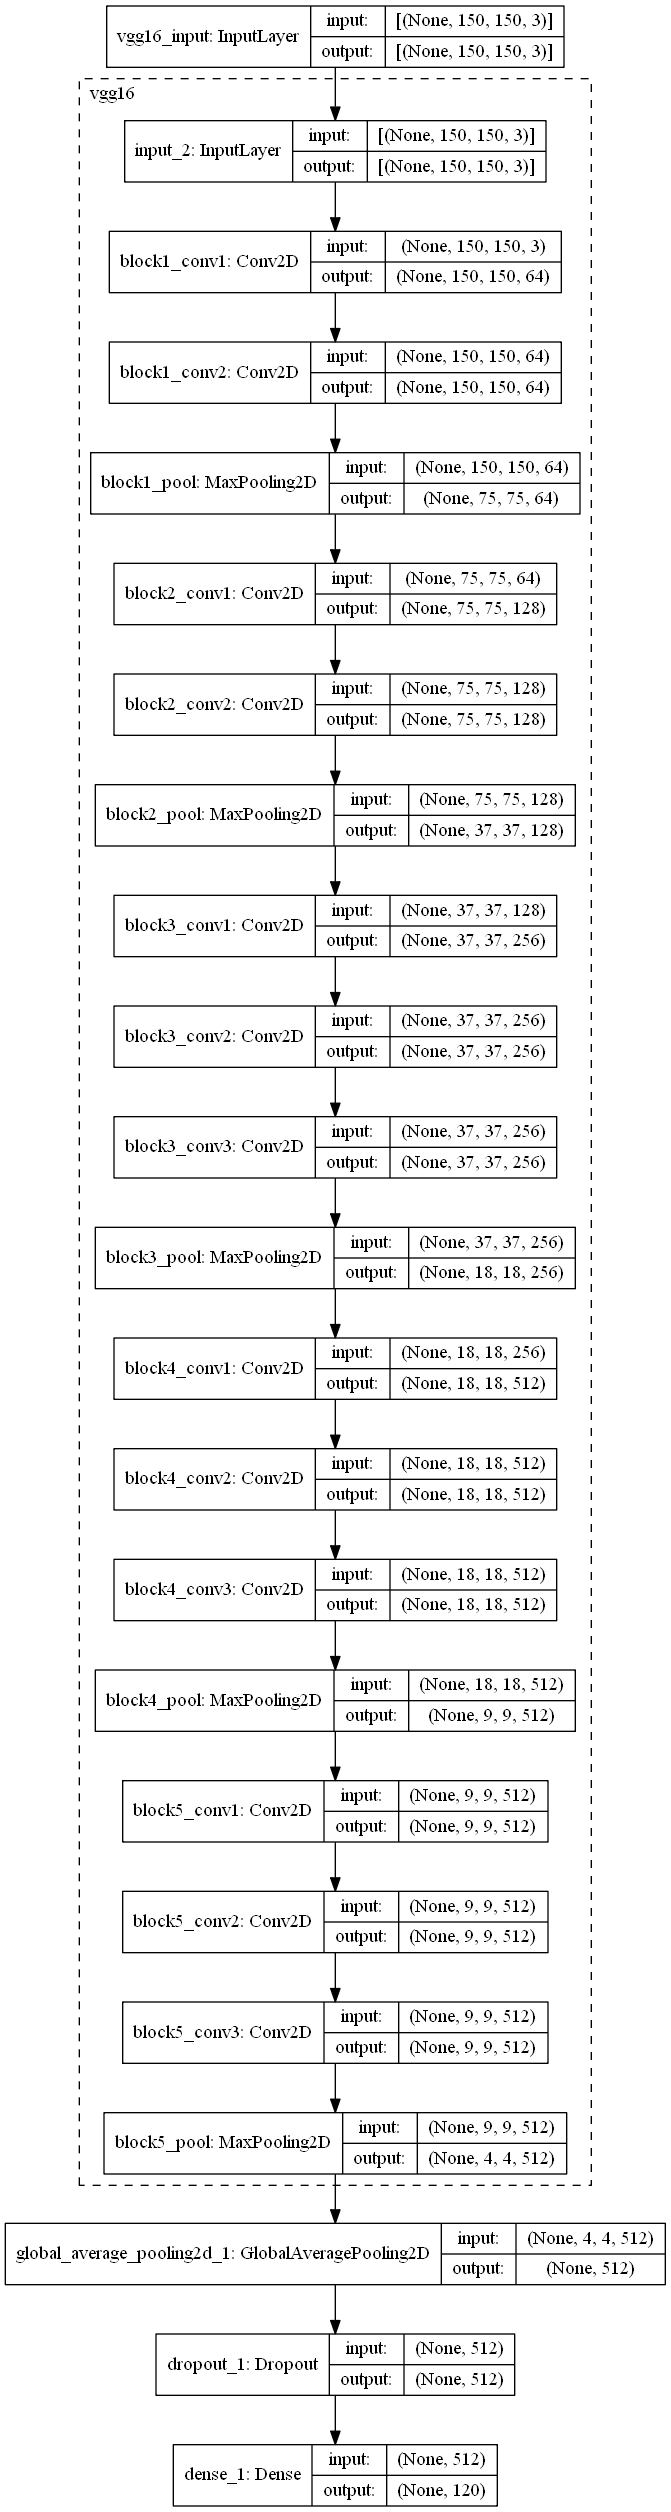

In [27]:
base_model = VGG16(include_top=False,
                  input_shape = (imgsize,imgsize,3),
                  weights = 'imagenet')

for layer in base_model.layers:
    layer.trainable = False
    
for layer in base_model.layers:
    print(layer,layer.trainable)

model = Sequential()
model.add(base_model)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(len(classes),activation='softmax'))
model.summary()

SVG(model_to_dot(model).create(prog='dot', format='svg'))
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True, expand_nested=True)

In [28]:
checkpoint = ModelCheckpoint(
    './base.model',
    monitor='val_loss',
    verbose=1,
    save_best_only=True,
    mode='min',
    save_weights_only=False,
    period=1
)
earlystop = EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=30,
    verbose=1,
    mode='auto'
)
tensorboard = TensorBoard(
    log_dir = './logs',
    histogram_freq=0,
    batch_size=16,
    write_graph=True,
    write_grads=True,
    write_images=False,
)

csvlogger = CSVLogger(
    filename= "training_csv.log",
    separator = ",",
    append = False
)

reduce = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.1,
    patience=3,
    verbose=1, 
    mode='auto'
)

callbacks = [checkpoint,tensorboard,csvlogger,reduce]

In [29]:
#-----------Optimizers-----------#
opt = SGD(lr=1e-4,momentum=0.99)
opt1 = Adam(lr=1e-2)
#----------Compile---------------#
model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=['accuracy']
)
#-----------Training------------#
history = model.fit_generator(
    img_gen.flow(X_train,y_train,batch_size=100),
    validation_data  = (X_test,y_test),
    validation_steps = 30,
    steps_per_epoch  = 35 ,
    epochs = 20,
    verbose = 1,
    callbacks=callbacks
)

C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/20
35/35 [==============================] - 89s 2s/step - loss: 5.0920 - accuracy: 0.0138 - val_loss: 4.7381 - val_accuracy: 0.0097

Epoch 00001: val_loss improved from inf to 4.73809, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 2/20
35/35 [==============================] - 83s 2s/step - loss: 4.8665 - accuracy: 0.0115 - val_loss: 4.6231 - val_accuracy: 0.0485

Epoch 00002: val_loss improved from 4.73809 to 4.62307, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 3/20
35/35 [==============================] - 84s 2s/step - loss: 4.7710 - accuracy: 0.0208 - val_loss: 4.5820 - val_accuracy: 0.0437

Epoch 00003: val_loss improved from 4.62307 to 4.58200, saving model to .\base.model
INFO:tensorflow:Assets written to: .\base.model\assets
Epoch 4/20
35/35 [==============================] - 84s 2s/step - loss: 4.6787 - accuracy: 0.0231 - val_loss: 4.5132 - val_accuracy: 0.0631

Epoch 00004: val_los

In [39]:
Predicted=model.predict(X)

In [43]:
Predicted

array([[1.4743535e-03, 6.1026303e-04, 4.0417789e-03, ..., 2.8187626e-03,
        6.2384596e-03, 1.2647806e-06],
       [7.7142711e-03, 9.6188048e-03, 1.4076261e-02, ..., 4.4386773e-03,
        1.2459634e-02, 5.0951794e-06],
       [4.3824557e-03, 3.6615967e-03, 8.2106078e-03, ..., 6.6032521e-03,
        1.9738359e-02, 2.1425010e-06],
       ...,
       [5.3660688e-03, 1.6150407e-02, 9.1987401e-03, ..., 4.4364491e-03,
        1.2134218e-02, 6.1812634e-06],
       [6.8515311e-03, 4.6755545e-02, 1.5810804e-02, ..., 1.0294720e-02,
        2.4919128e-02, 1.1176628e-05],
       [8.6786197e-03, 4.9802627e-02, 1.7119929e-02, ..., 7.5402129e-03,
        1.5179538e-02, 1.2183533e-05]], dtype=float32)

In [51]:
clustering = KMeans(n_clusters=10,init='random',random_state=0, n_init=10).fit(Predicted)
clusters = clustering.labels_

In [103]:
labels=[]
for i in classes:
    labels.append(i.split('-')[-1])
matrix = {}
for label in labels:
    matrix[label] = [0]*10
index=0
for i in clusters:
    matrix[label_encoder.inverse_transform([np.argmax(Y[index])])[0]][i]+=1
    index+=1

In [104]:
matrix

{'Chihuahua': [0, 54, 12, 49, 7, 4, 21, 1, 2, 2],
 'Japanese_spaniel': [0, 17, 122, 0, 5, 15, 18, 4, 1, 3],
 'Maltese_dog': [0, 17, 213, 0, 0, 4, 13, 0, 0, 5],
 'Pekinese': [0, 16, 54, 3, 11, 19, 29, 0, 0, 17],
 'Tzu': [0, 26, 96, 1, 11, 21, 36, 0, 0, 23],
 'Blenheim_spaniel': [0, 29, 36, 0, 34, 24, 14, 48, 2, 1],
 'papillon': [0, 26, 121, 8, 4, 5, 25, 0, 2, 5],
 'toy_terrier': [1, 59, 2, 83, 1, 2, 21, 0, 3, 0],
 'Rhodesian_ridgeback': [0, 65, 2, 0, 38, 8, 54, 0, 5, 0],
 'Afghan_hound': [0, 24, 12, 0, 3, 94, 98, 0, 1, 7],
 'basset': [0, 53, 7, 3, 70, 8, 25, 1, 8, 0],
 'beagle': [1, 50, 4, 2, 101, 7, 15, 2, 13, 0],
 'bloodhound': [0, 63, 2, 1, 43, 22, 40, 0, 16, 0],
 'bluetick': [1, 62, 0, 4, 17, 3, 50, 0, 34, 0],
 'tan_coonhound': [3, 47, 0, 1, 10, 2, 47, 0, 49, 0],
 'Walker_hound': [0, 79, 0, 1, 54, 2, 10, 1, 6, 0],
 'English_foxhound': [0, 85, 1, 0, 44, 3, 17, 1, 6, 0],
 'redbone': [0, 80, 2, 0, 37, 7, 17, 0, 5, 0],
 'borzoi': [0, 40, 32, 0, 5, 23, 49, 0, 1, 1],
 'Irish_wolfhound': [

In [106]:
cluster_breed={}
for label in labels:
    cluster_breed[label] = np.argmax(matrix[label])
cluster_breed

{'Chihuahua': 1,
 'Japanese_spaniel': 2,
 'Maltese_dog': 2,
 'Pekinese': 2,
 'Tzu': 2,
 'Blenheim_spaniel': 7,
 'papillon': 2,
 'toy_terrier': 3,
 'Rhodesian_ridgeback': 1,
 'Afghan_hound': 6,
 'basset': 4,
 'beagle': 4,
 'bloodhound': 1,
 'bluetick': 1,
 'tan_coonhound': 8,
 'Walker_hound': 1,
 'English_foxhound': 1,
 'redbone': 1,
 'borzoi': 6,
 'Irish_wolfhound': 6,
 'Italian_greyhound': 1,
 'whippet': 1,
 'Ibizan_hound': 1,
 'Norwegian_elkhound': 1,
 'otterhound': 5,
 'Saluki': 1,
 'Scottish_deerhound': 6,
 'Weimaraner': 1,
 'Staffordshire_bullterrier': 1,
 'American_Staffordshire_terrier': 1,
 'Bedlington_terrier': 1,
 'Border_terrier': 5,
 'Kerry_blue_terrier': 6,
 'Irish_terrier': 5,
 'Norfolk_terrier': 9,
 'Norwich_terrier': 9,
 'Yorkshire_terrier': 9,
 'haired_fox_terrier': 1,
 'Lakeland_terrier': 6,
 'Sealyham_terrier': 2,
 'Airedale': 6,
 'cairn': 6,
 'Australian_terrier': 9,
 'Dandie_Dinmont': 9,
 'Boston_bull': 1,
 'miniature_schnauzer': 6,
 'giant_schnauzer': 6,
 'standar

In [121]:
breed_clusters={}
for i in range(0,10):
    breed_clusters[i]=[]
for label in labels:
    breed_clusters[cluster_breed[label]].append(label)
breed_clusters

{0: [],
 1: ['Chihuahua',
  'Rhodesian_ridgeback',
  'bloodhound',
  'bluetick',
  'Walker_hound',
  'English_foxhound',
  'redbone',
  'Italian_greyhound',
  'whippet',
  'Ibizan_hound',
  'Norwegian_elkhound',
  'Saluki',
  'Weimaraner',
  'Staffordshire_bullterrier',
  'American_Staffordshire_terrier',
  'Bedlington_terrier',
  'haired_fox_terrier',
  'Boston_bull',
  'haired_pointer',
  'vizsla',
  'Brittany_spaniel',
  'English_springer',
  'Welsh_springer_spaniel',
  'schipperke',
  'malinois',
  'Doberman',
  'miniature_pinscher',
  'French_bulldog',
  'Great_Dane',
  'Eskimo_dog',
  'Siberian_husky',
  'basenji',
  'pug',
  'Brabancon_griffon',
  'Mexican_hairless'],
 2: ['Japanese_spaniel',
  'Maltese_dog',
  'Pekinese',
  'Tzu',
  'papillon',
  'Sealyham_terrier',
  'West_Highland_white_terrier',
  'Lhasa',
  'clumber',
  'kuvasz',
  'Old_English_sheepdog',
  'Shetland_sheepdog',
  'Great_Pyrenees',
  'Samoyed',
  'Pomeranian',
  'chow',
  'keeshond',
  'toy_poodle',
  'minia

In [125]:
test_img = 'data/golden.jpg'

path = test_img
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.resize(img,(imgsize,imgsize))

test_img = np.array(img)
test_img = test_img/255

In [130]:
predict = [np.argmax(model.predict(test_img.reshape(-1, 150, 150, 3)))]
predicted_cluster=cluster_breed[label_encoder.inverse_transform(predict)[0]]

In [131]:
indexes=[]
index=0
for i in Z:
    if(i in breed_clusters[predicted_cluster]):
        indexes.append(index)
    index+=1    

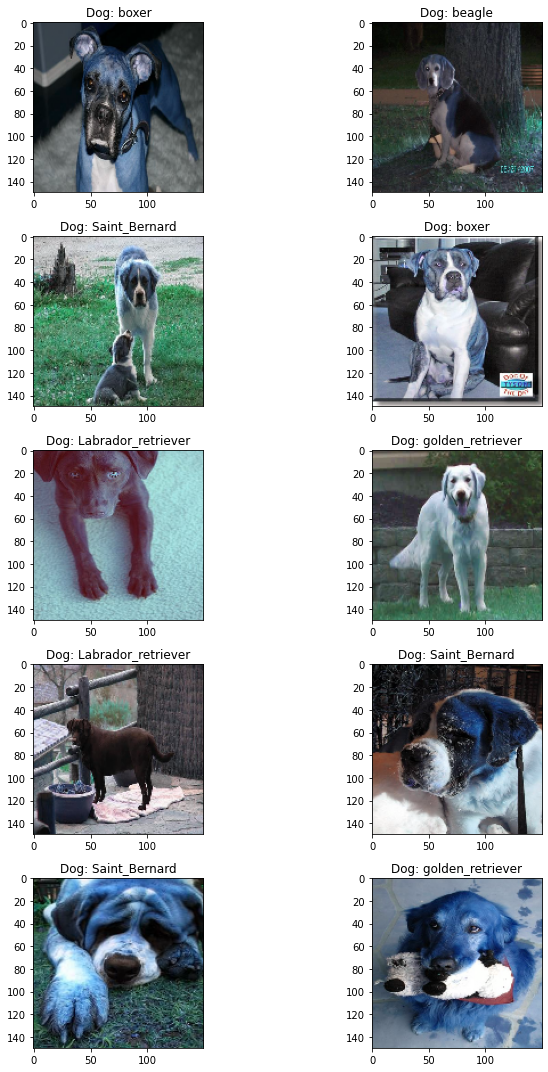

In [141]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)


for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(indexes))
        ax[i,j].imshow(X[indexes[l]])
        ax[i,j].set_title('Dog: '+Z[indexes[l]])
        

        plt.tight_layout()

In [151]:
test_img = 'data/spaniel.jpg'

path = test_img
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.resize(img,(imgsize,imgsize))

test_img = np.array(img)
test_img = test_img/255

In [152]:
predict = [np.argmax(model.predict(test_img.reshape(-1, 150, 150, 3)))]
predicted_cluster=cluster_breed[label_encoder.inverse_transform(predict)[0]]

In [153]:
indexes=[]
index=0
for i in Z:
    if(i in breed_clusters[predicted_cluster]):
        indexes.append(index)
    index+=1    

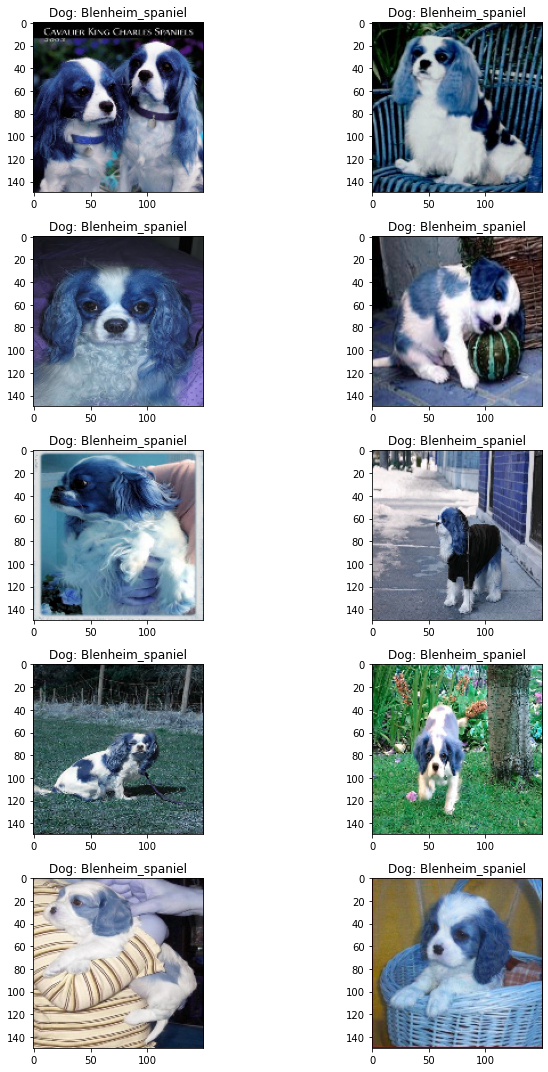

In [154]:
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)


for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(indexes))
        ax[i,j].imshow(X[indexes[l]])
        ax[i,j].set_title('Dog: '+Z[indexes[l]])
        

        plt.tight_layout()

In [63]:
model2 = keras.models.load_model('base.model')

In [64]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 120)               61560     
Total params: 14,776,248
Trainable params: 14,776,248
Non-trainable params: 0
_________________________________________________________________


In [65]:
model2.pop()
model2.pop()

In [66]:
model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 4, 4, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_1 ( (None, 512)               0         
Total params: 14,714,688
Trainable params: 14,714,688
Non-trainable params: 0
_________________________________________________________________


In [67]:
X.shape

(20580, 150, 150, 3)

In [68]:
# limit = X.shape[0]//200
# Predicted = []
# for i in range(limit):
#     t = X[i*200:(i+1)*200]
#     print(t.shape)
#     p = model2.predict(t)
#     Predicted.append(p)
Predicted=model2.predict(X)

In [69]:
clustering = KMeans(n_clusters=10,init='random',random_state=0, n_init=10).fit(Predicted)
clusters = clustering.labels_

In [89]:
labels=[]
for i in classes:
    labels.append(i.split('-')[-1])
matrix = {}
for label in labels:
    matrix[label] = [0]*10
index=0
for i in clusters:
    matrix[label_encoder.inverse_transform([np.argmax(Y[index])])[0]][i]+=1
    index+=1
matrix    

{'Chihuahua': [4, 15, 5, 5, 38, 7, 12, 45, 4, 17],
 'Japanese_spaniel': [47, 39, 2, 3, 0, 38, 19, 25, 3, 9],
 'Maltese_dog': [69, 34, 0, 1, 0, 47, 21, 56, 1, 23],
 'Pekinese': [29, 26, 1, 17, 3, 23, 10, 20, 3, 17],
 'Tzu': [48, 43, 2, 7, 0, 40, 28, 25, 3, 18],
 'Blenheim_spaniel': [38, 28, 14, 32, 1, 15, 7, 29, 11, 13],
 'papillon': [34, 29, 2, 2, 13, 44, 29, 26, 4, 13],
 'toy_terrier': [1, 8, 8, 1, 49, 4, 20, 51, 7, 23],
 'Rhodesian_ridgeback': [0, 8, 35, 27, 0, 5, 33, 26, 16, 22],
 'Afghan_hound': [29, 45, 14, 7, 0, 27, 31, 13, 32, 41],
 'basset': [2, 21, 4, 41, 1, 13, 10, 44, 13, 26],
 'beagle': [3, 12, 18, 79, 0, 9, 5, 29, 21, 19],
 'bloodhound': [0, 12, 23, 24, 0, 15, 15, 44, 26, 28],
 'bluetick': [0, 13, 18, 24, 0, 17, 12, 36, 27, 24],
 'tan_coonhound': [0, 3, 37, 30, 1, 8, 17, 22, 26, 15],
 'Walker_hound': [0, 12, 39, 25, 0, 10, 5, 44, 7, 11],
 'English_foxhound': [0, 4, 62, 19, 0, 9, 11, 29, 4, 19],
 'redbone': [0, 7, 11, 31, 0, 12, 8, 40, 11, 28],
 'borzoi': [12, 10, 38, 4, 0,

In [90]:
cluster_breed={}
for label in labels:
    cluster_breed[label] = np.argmax(matrix[label])

In [91]:
breed_clusters={}
for i in range(0,10):
    breed_clusters[i]=[]
for label in labels:
    breed_clusters[cluster_breed[label]].append(label)
breed_clusters

{0: ['Japanese_spaniel',
  'Maltese_dog',
  'Pekinese',
  'Tzu',
  'Blenheim_spaniel',
  'Norfolk_terrier',
  'Norwich_terrier',
  'Sealyham_terrier',
  'cairn',
  'Australian_terrier',
  'Dandie_Dinmont',
  'Tibetan_terrier',
  'silky_terrier',
  'West_Highland_white_terrier',
  'Lhasa',
  'clumber',
  'Old_English_sheepdog',
  'Shetland_sheepdog',
  'collie',
  'Pomeranian',
  'chow'],
 1: ['Afghan_hound',
  'Irish_terrier',
  'Yorkshire_terrier',
  'miniature_schnauzer',
  'standard_schnauzer',
  'English_springer',
  'Sussex_spaniel',
  'Bernese_mountain_dog',
  'standard_poodle'],
 2: ['Rhodesian_ridgeback',
  'tan_coonhound',
  'English_foxhound',
  'borzoi',
  'whippet',
  'Ibizan_hound',
  'otterhound',
  'Saluki',
  'Bedlington_terrier',
  'haired_fox_terrier',
  'Great_Dane'],
 3: ['beagle',
  'Border_terrier',
  'golden_retriever',
  'Labrador_retriever',
  'Brittany_spaniel',
  'Welsh_springer_spaniel',
  'cocker_spaniel',
  'Rottweiler',
  'boxer',
  'bull_mastiff',
  'Sai

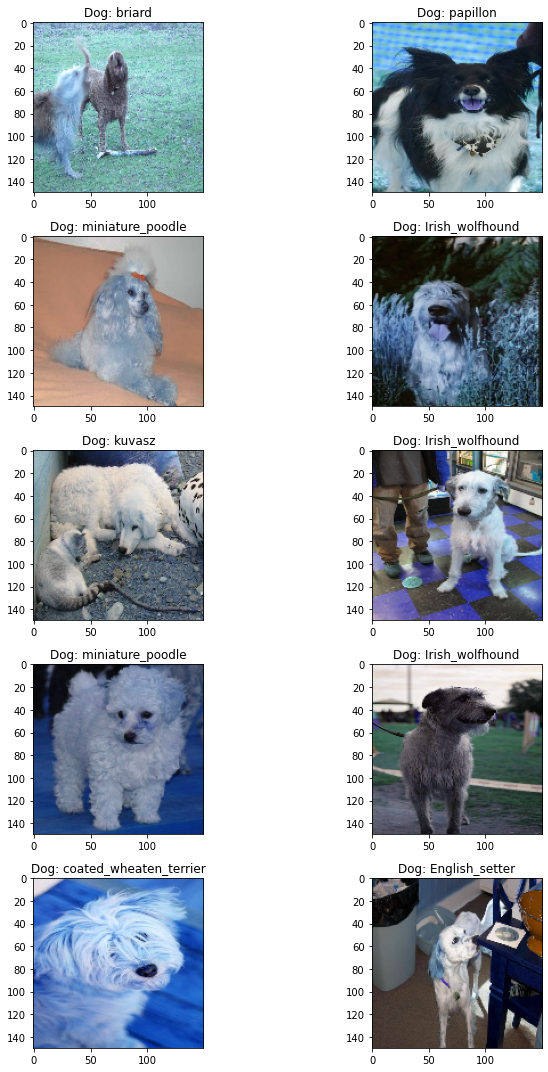

In [87]:
test_img = 'data/afgan.jpg'

path = test_img
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.resize(img,(imgsize,imgsize))

test_img = np.array(img)
test_img = test_img/255

p=model2.predict(test_img.reshape((1, 150, 150, 3)))
predicted_cluster=clustering.predict(p)[0]

indexes=[]
index=0
for i in Z:
    if(i in breed_clusters[predicted_cluster]):
        indexes.append(index)
    index+=1    
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)


for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(indexes))
        ax[i,j].imshow(X[indexes[l]])
        ax[i,j].set_title('Dog: '+Z[indexes[l]])
        

        plt.tight_layout()

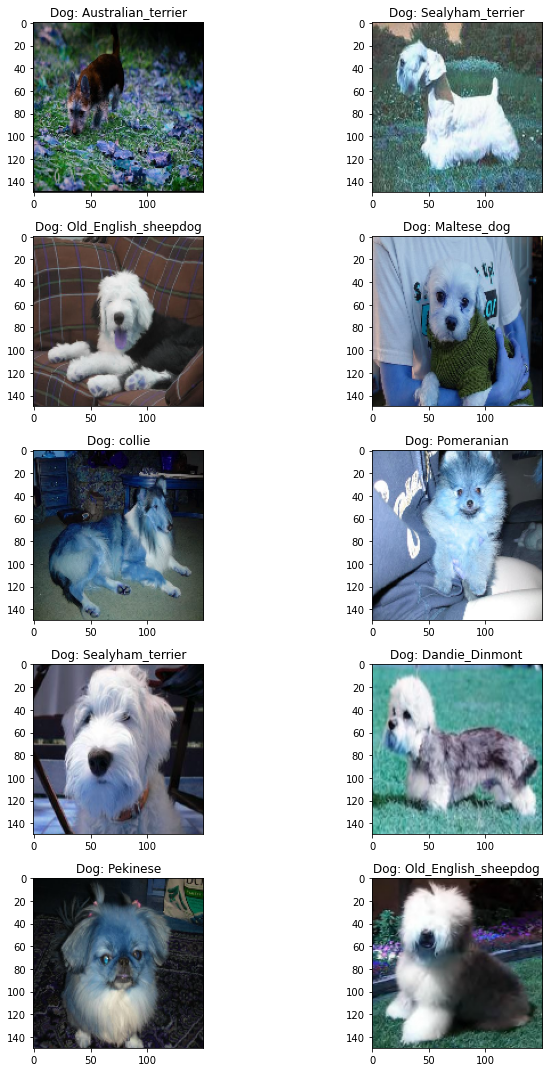

In [85]:
test_img = 'data/maltese.jpg'

path = test_img
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.resize(img,(imgsize,imgsize))

test_img = np.array(img)
test_img = test_img/255

p=model2.predict(test_img.reshape((1, 150, 150, 3)))
predicted_cluster=clustering.predict(p)[0]

indexes=[]
index=0
for i in Z:
    if(i in breed_clusters[predicted_cluster]):
        indexes.append(index)
    index+=1    
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)


for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(indexes))
        ax[i,j].imshow(X[indexes[l]])
        ax[i,j].set_title('Dog: '+Z[indexes[l]])
        

        plt.tight_layout()

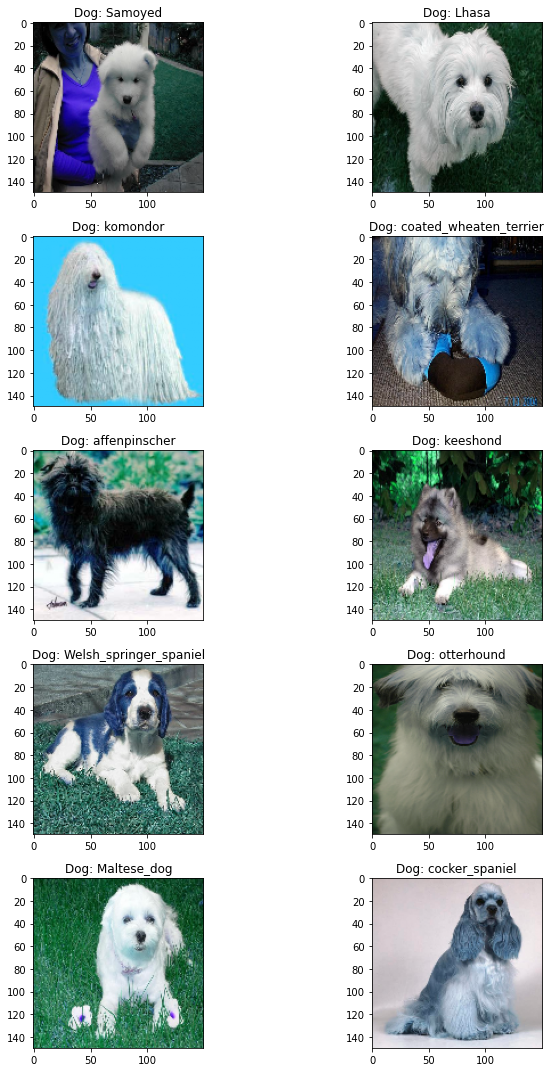

In [92]:
test_img = 'data/maltese.jpg'

path = test_img
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.resize(img,(imgsize,imgsize))

test_img = np.array(img)
test_img = test_img/255

p=model2.predict(test_img.reshape((1, 150, 150, 3)))
predicted_cluster=clustering.predict(p)[0]

indexes=[]
index=0
for i in Z:
    if(clusters[index] == predicted_cluster):
        indexes.append(index)
    index+=1    
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)


for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(indexes))
        ax[i,j].imshow(X[indexes[l]])
        ax[i,j].set_title('Dog: '+Z[indexes[l]])
        

        plt.tight_layout()

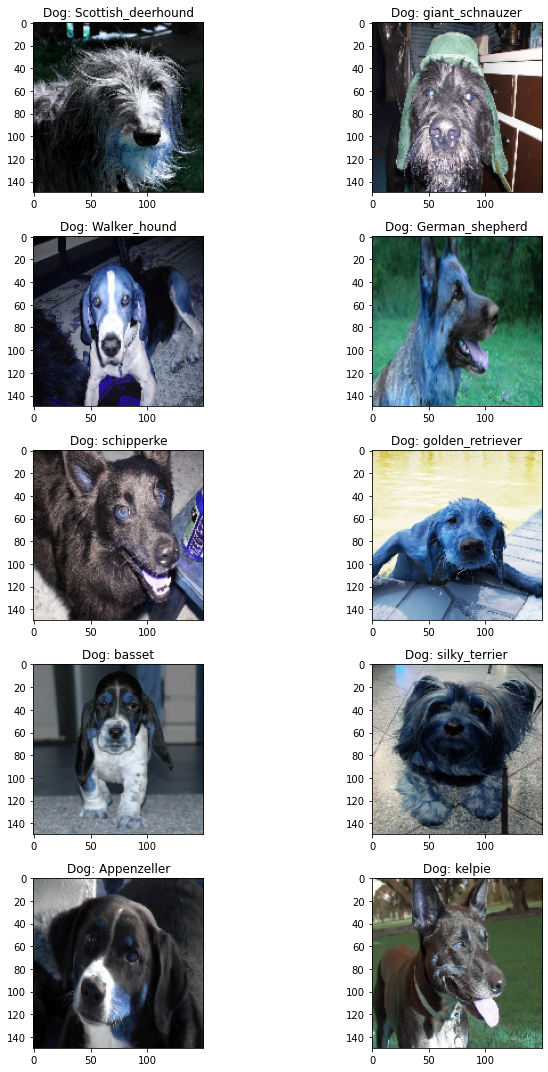

In [97]:
test_img = 'data/golden.jpg'

path = test_img
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.resize(img,(imgsize,imgsize))

test_img = np.array(img)
test_img = test_img/255

p=model2.predict(test_img.reshape((1, 150, 150, 3)))
predicted_cluster=clustering.predict(p)[0]

indexes=[]
index=0
for i in Z:
    if(clusters[index] == predicted_cluster):
        indexes.append(index)
    index+=1    
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)


for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(indexes))
        ax[i,j].imshow(X[indexes[l]])
        ax[i,j].set_title('Dog: '+Z[indexes[l]])
        

        plt.tight_layout()

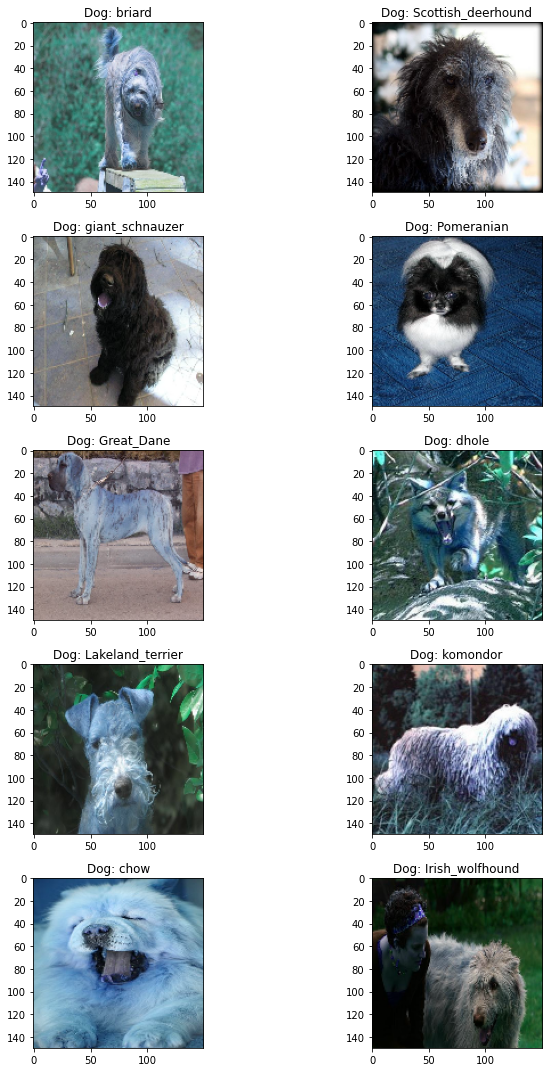

In [96]:
test_img = 'data/afgan.jpg'

path = test_img
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.resize(img,(imgsize,imgsize))

test_img = np.array(img)
test_img = test_img/255

p=model2.predict(test_img.reshape((1, 150, 150, 3)))
predicted_cluster=clustering.predict(p)[0]

indexes=[]
index=0
for i in Z:
    if(clusters[index] == predicted_cluster):
        indexes.append(index)
    index+=1    
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)


for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(indexes))
        ax[i,j].imshow(X[indexes[l]])
        ax[i,j].set_title('Dog: '+Z[indexes[l]])
        

        plt.tight_layout()

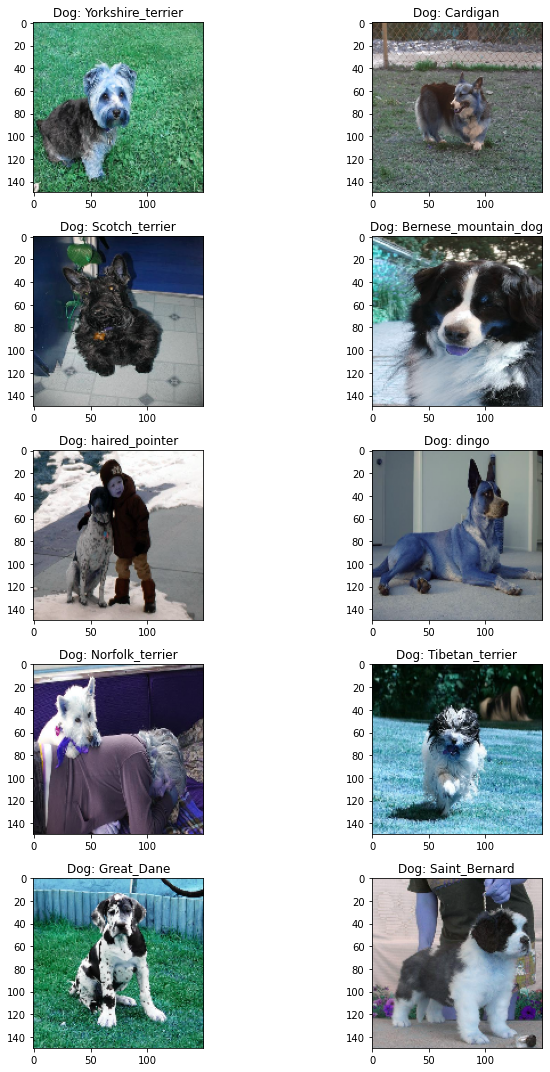

In [95]:
test_img = 'data/spaniel.jpg'

path = test_img
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.resize(img,(imgsize,imgsize))

test_img = np.array(img)
test_img = test_img/255

p=model2.predict(test_img.reshape((1, 150, 150, 3)))
predicted_cluster=clustering.predict(p)[0]

indexes=[]
index=0
for i in Z:
    if(clusters[index] == predicted_cluster):
        indexes.append(index)
    index+=1    
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)


for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(indexes))
        ax[i,j].imshow(X[indexes[l]])
        ax[i,j].set_title('Dog: '+Z[indexes[l]])
        

        plt.tight_layout()

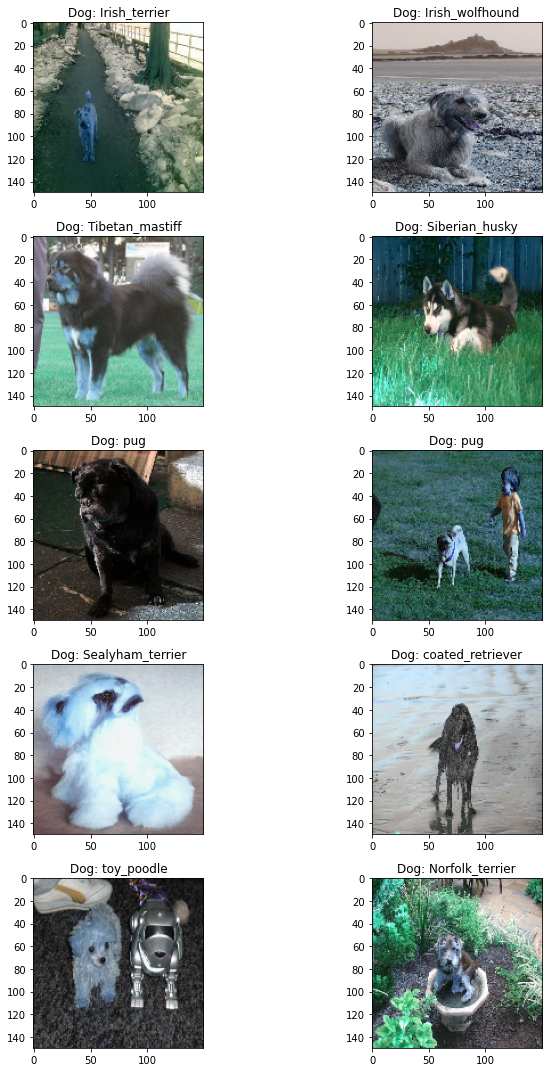

In [103]:
test_img = 'data/shah.jpeg'

path = test_img
img = cv2.imread(path,cv2.IMREAD_COLOR)
img = cv2.resize(img,(imgsize,imgsize))

test_img = np.array(img)
test_img = test_img/255

p=model2.predict(test_img.reshape((1, 150, 150, 3)))
predicted_cluster=clustering.predict(p)[0]

indexes=[]
index=0
for i in Z:
    if(clusters[index] == predicted_cluster):
        indexes.append(index)
    index+=1    
fig,ax=plt.subplots(5,2)
fig.set_size_inches(15,15)


for i in range(5):
    for j in range (2):
        l=rn.randint(0,len(indexes))
        ax[i,j].imshow(X[indexes[l]])
        ax[i,j].set_title('Dog: '+Z[indexes[l]])
        

        plt.tight_layout()